---

# KDDCUP99

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')
print('[INFO] -> Using Device: ', device)

[INFO] -> Using Device:  cuda:0


In [3]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y


def get_KDDCUP99_REV(PATH, seed, scale = True, show = False):
    
    columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_hot_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
        'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate', 'label'] 
    
    df = pd.read_csv(PATH, header=None, names=columns)
    discreteCol = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_hot_login', 'is_guest_login']
    
    names = []
    oneHot = dict()
    for name in discreteCol:
        n, t = _encode_text_dummy(df, name)
        names.extend(n)
        oneHot[name] = t
        
    # Delete nepture, smurf
    df_neptune = df[df['label'] == 'neptune.']
    df_smurf = df[df['label'] == 'smurf.']
    df = df.loc[~df.index.isin(df_neptune.index)]
    df = df.loc[~df.index.isin(df_smurf.index)]

    labels = df['label'].copy()
    labels[labels != 'normal.'] = 1 # anomalous
    labels[labels == 'normal.'] = 0 # normal

    df['label'] = labels
    normal = df[df['label'] == 0] 
    abnormal = df[df['label'] == 1]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)

    abnormal_1 = abnormal[:int(len(abnormal)*.5)]
    abnormal_2 = abnormal[int(len(abnormal)*.5):]

    test_size_ab = int(len(abnormal_1)*(3/4))
    val_size_ab = int(len(abnormal_1)*(1/4))

    test_size_n = int(.15 * (len(normal) + len(abnormal_1)) - test_size_ab + 1)
    val_size_n = int(.05 * (len(normal) + len(abnormal_1)) - val_size_ab + 1)

    train_size = int(len(normal) - val_size_n - test_size_n)+1

    train_set = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size_n]
    test_normal = normal[train_size+val_size_n: ]

    val_abnormal = abnormal[:val_size_ab]
    test_abnormal = abnormal[val_size_ab:val_size_ab+test_size_ab]

    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))

    x_train, y_train = _to_xy(train_set, target='label')
    x_val, y_val = _to_xy(val_set, target='label')
    x_test, y_test = _to_xy(test_set, target='label')
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print(f'We use {len(abnormal_1)} anomalous records')
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == 0])} normal records and {len(x_train[y_train == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == 0])} normal records and {len(x_val[y_val == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == 0])} normal records and {len(x_test[y_test == 1])} abnormal records')

    selected_columns = dict()
    
    for name in discreteCol:
        cols = [col for col in names if name in col]
        tmp = []
        
        for c in cols:
            tmp.append(x_train.columns.get_loc(c))

        selected_columns[name] = tmp
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
    
    index = np.arange(0, len(columns)-len(discreteCol)-1)

    if scale:
        scaler = MinMaxScaler()
        scaler.fit(x_train[:, index])
        x_train[:, index] = scaler.transform(x_train[:, index])
        x_val[:, index] = scaler.transform(x_val[:, index])
        x_test[:, index] = scaler.transform(x_test[:, index])
        
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['selectedColumns'] = selected_columns
    dataset['discreteCol'] = discreteCol
    dataset['oneHot'] = oneHot
    dataset['index'] = index
    dataset['scaler'] = scaler
    
    return dataset

In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'

FILE = 'kddcup.data_10_percent_corrected'

DATASET = 'KDDCUP99'

PATH = os.path.join(WORK_SPACE, FILE)

In [5]:
dataset = get_KDDCUP99_REV(PATH, seed, show=True)

97278 normal records, 8752 anormal records
We use 4376 anomalous records
-----------------------------------------------------------------------------------------
There are 81323 records in training set
Training set is composed by 81323 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 5083 records in validation set
Validation set is composed by 3989 normal records and 1094 abnormal records
-----------------------------------------------------------------------------------------
There are 15248 records in test set
Test set is composed by 11966 normal records and 3282 abnormal records


## Model

In [13]:
def meanAUC_PRAUC(auc_list, pr_list, name):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    FILE_NAME = f'{name}.csv'

    AUC_Frame.to_csv(os.path.join(WORK_SPACE, 'auc', FILE_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(WORK_SPACE, 'auc_PR', FILE_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [6]:


def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1).to(device)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y


class Autoencoder(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Autoencoder, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), # 121@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out), # 64@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out, self.z_dim), # 32@16
            nn.BatchNorm1d(self.z_dim, track_running_stats = False),
            nn.LeakyReLU(0.2)
        
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.nf_out), # 16@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.ReLU(),
            
            nn.Linear(self.nf_out, self.nf_out * 2), # 32@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_in) # 64@121
        )
        
        self.sigmoid = nn.Sigmoid()

        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x, text_l, selected_columnsTrain, index, t=1):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        rec = dec.clone()
        rec[:, index] = self.sigmoid(dec[:, index])
        for name in text_l:
            rec[:, selected_columnsTrain[name]] = self.gumbel(dec[:, selected_columnsTrain[name]], t)
        
        return rec
    
    
class Loss(nn.Module):
    def __init__(self, text_l, selected_columnsTrain, index):
        super(Loss, self).__init__()
        
        self.text_l = text_l
        self.selected_columnsTrain = selected_columnsTrain
        self.index = index
        
        self.mse = nn.MSELoss(reduction = 'mean')
    
    def reconstruction(self, true_data, rec_data):
        g1 = self.mse(true_data[:, self.index], rec_data[:, self.index])
        g2 = 0
        for name in self.text_l:
            y = true_data[:, self.selected_columnsTrain[name]]
            y_p = rec_data[:, self.selected_columnsTrain[name]]
            g2 += self.mse(y_p, y)
        g2 /= len(self.text_l)
        return g1 + 0.5 * g2

    def forward(self, true_data, rec_data):
        rec = self.reconstruction(true_data, rec_data)
        return rec
    

class BaselineTrainer(nn.Module):
    def __init__(self, device, selected_columns, discreteCol, index, nc):
        super(BaselineTrainer, self).__init__()
        self.device = device
        self.selected_columns = selected_columns
        self.discreteCol = discreteCol
        self.index = index
        self.nc = nc

        self.AE = Autoencoder(nf_in = self.nc).to(self.device)

        self.ae_optimizer = torch.optim.Adam(self.AE.parameters(), lr=1e-4)
        self.loss = Loss(self.discreteCol, self.selected_columns, self.index)
        
        self.temperature = 1
        self.anneal = 0.9995
        self.criterion = nn.MSELoss(reduction = 'mean')

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
            
    def evaluation(self, test_loader):
        self.AE.eval()
        aeL = []
    
        for batch, label in test_loader:
            
            with torch.no_grad():
                rec_data = self.AE(batch, self.discreteCol, self.selected_columns, self.index, self.temperature)   
                ae_loss_batch = self.loss(batch, rec_data)
                
            aeL.append(ae_loss_batch.item())
            
        return np.mean(aeL)
    
    
    def AE_step(self, true_data):
        self.AE.zero_grad()
        
        rec_data = self.AE(true_data, self.discreteCol, self.selected_columns, self.index, self.temperature)    
        
        ae_loss_batch = self.loss(true_data, rec_data)
        ae_loss_batch.backward()

        self.ae_optimizer.step()

        return ae_loss_batch
    
    def predict(self, test_loader):
        self.AE.eval()
        
        i = 0

        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                rec_data = self.AE(batch, self.discreteCol, self.selected_columns, self.index)
             
            err = []
            for b, r in zip(batch, rec_data):
                mse1 = self.criterion(b[self.index], r[self.index])
                
                mse2 = 0
                for name in self.discreteCol:
                    b1 = b[self.selected_columns[name]]
                    r1 = r[self.selected_columns[name]]
                    
                    mse2 += self.criterion(b1, r1)
                mse2 /= len(self.discreteCol)
                
                mse = mse1 + 0.5 * mse2
                
                p = 1-torch.exp(-mse)
                err.append(p.item())
                
            if i == 0:
                y_true = label.cpu()
                pred = torch.tensor(err)
            else:
                y_true = torch.cat((y_true, label.cpu()))
                pred = torch.cat((pred, torch.tensor(err)))

            i += 1
                
        return y_true, pred
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
    def plotLoss(self, ae_losses, ae_losses_val):
        num_epochs = len(ae_losses)


        plt.figure()
        plt.xlim(0, num_epochs + 1)
        plt.plot(range(1, num_epochs + 1), ae_losses[:num_epochs], label='ae loss')
        plt.plot(range(1, num_epochs + 1), ae_losses_val[:num_epochs], '--', label='ae loss val')

        plt.legend()
        plt.show()  

        
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15):
        
        ae_losses = np.zeros(num_epochs)
        ae_losses_val = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            for epoch in range(num_epochs):
                self.AE.train()
                
                i = 0
                for batch in data_loader:
                    batch = batch.to(self.device)
                    
                    ae_loss = self.AE_step(batch)
                    ae_losses[epoch] = ae_losses[epoch]*(i/(i+1.)) + ae_loss.item()*(1./(i+1.))
                    
                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    if (i+1) % step == 0:
                        sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | Step [{:>3}/{}]| ae_loss: {:.4f} '
                              .format(epoch+1, num_epochs, i+1, total_steps, ae_loss.item()))
                        sys.stdout.flush()
                        
                    i += 1
                
                aeLossVal = self.evaluation(test_loader)
                ae_losses_val[epoch] = aeLossVal
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        self.plotLoss(ae_losses, ae_losses_val)
        return ae_losses[:epoch], ae_losses_val[:epoch]

#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0042 
[INFO] Training phase... Elapsed time: 58 seconds



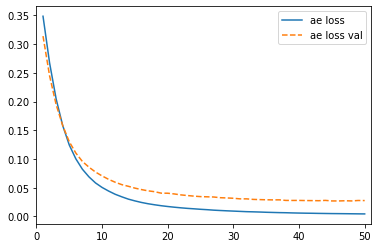

PR AUC: 0.86


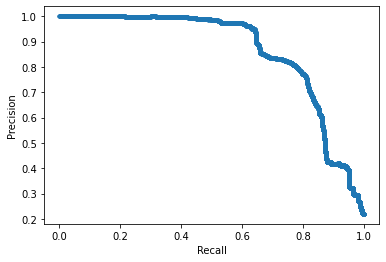

AUC: 0.92
Iteration: 2
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0048 
[INFO] Training phase... Elapsed time: 58 seconds



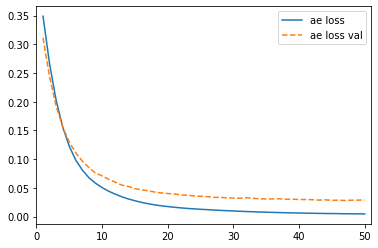

PR AUC: 0.85


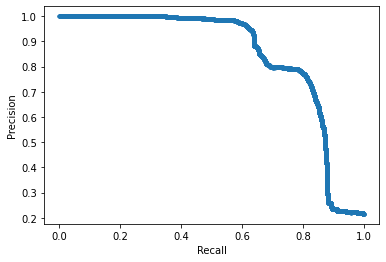

AUC: 0.88
Iteration: 3
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0048 
[INFO] Training phase... Elapsed time: 58 seconds



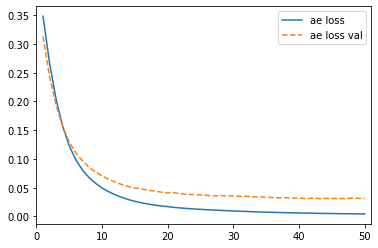

PR AUC: 0.88


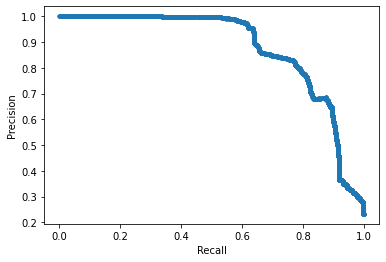

AUC: 0.93
Iteration: 4
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0042 
[INFO] Training phase... Elapsed time: 58 seconds



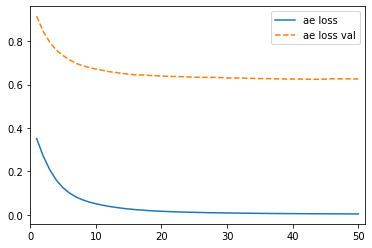

PR AUC: 0.90


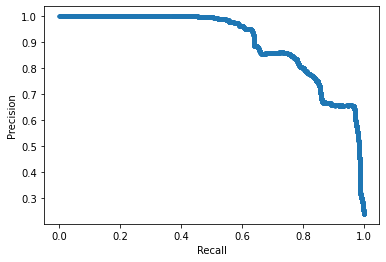

AUC: 0.96
Iteration: 5
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 58 seconds



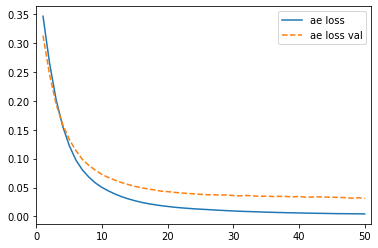

PR AUC: 0.87


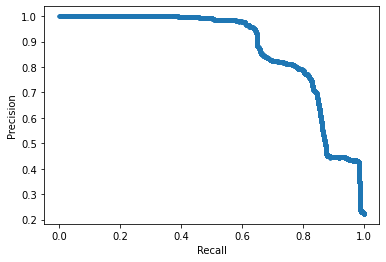

AUC: 0.94
Iteration: 6
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0043 
[INFO] Training phase... Elapsed time: 60 seconds



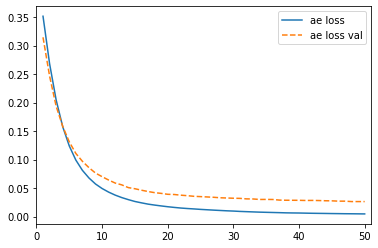

PR AUC: 0.85


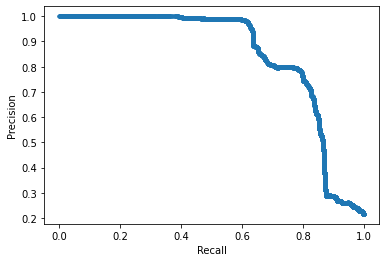

AUC: 0.89
Iteration: 7
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0043 
[INFO] Training phase... Elapsed time: 59 seconds



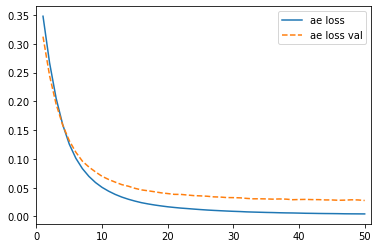

PR AUC: 0.85


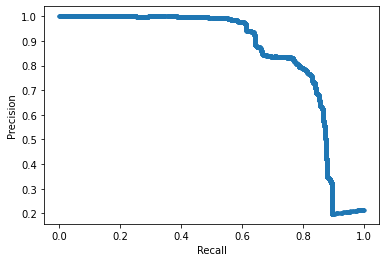

AUC: 0.87
Iteration: 8
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 60 seconds



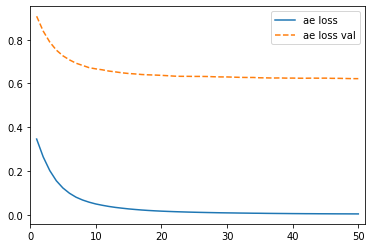

PR AUC: 0.85


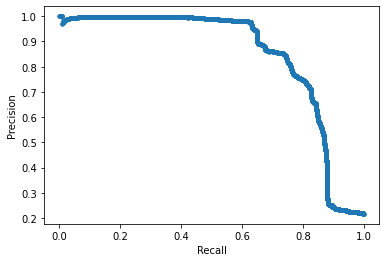

AUC: 0.88
Iteration: 9
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 59 seconds



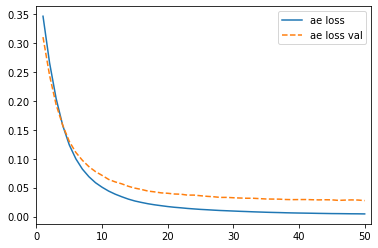

PR AUC: 0.87


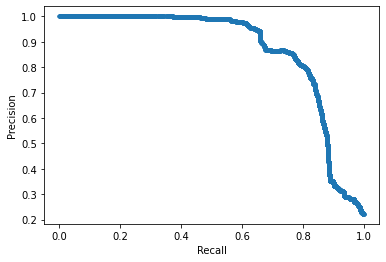

AUC: 0.91
Iteration: 10
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 59 seconds



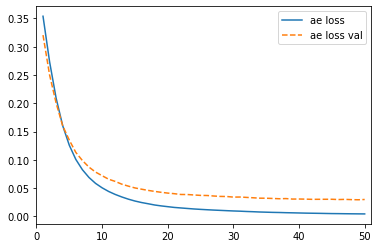

PR AUC: 0.87


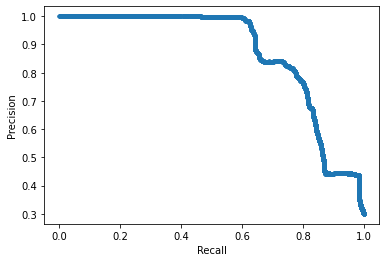

AUC: 0.94
Iteration: 11
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0039 
[INFO] Training phase... Elapsed time: 58 seconds



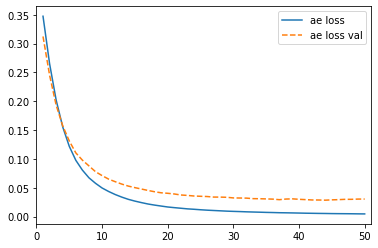

PR AUC: 0.87


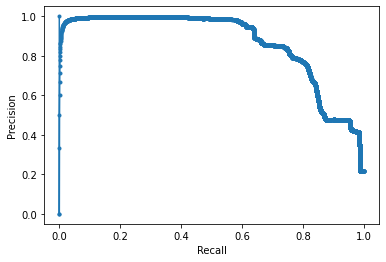

AUC: 0.94
Iteration: 12
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 58 seconds



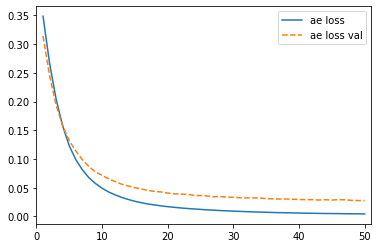

PR AUC: 0.91


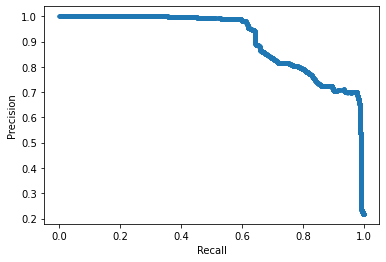

AUC: 0.97
Iteration: 13
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0040 
[INFO] Training phase... Elapsed time: 58 seconds



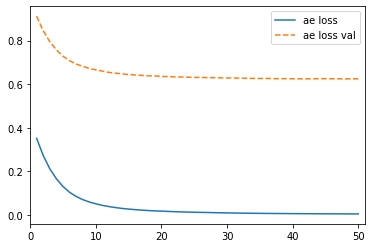

PR AUC: 0.87


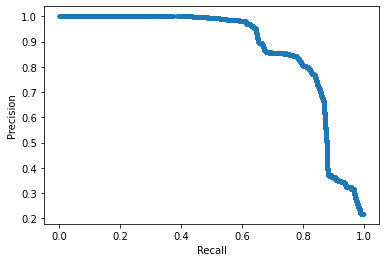

AUC: 0.92
Iteration: 14
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0047 
[INFO] Training phase... Elapsed time: 58 seconds



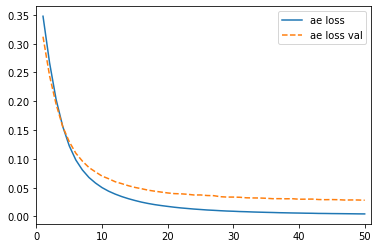

PR AUC: 0.88


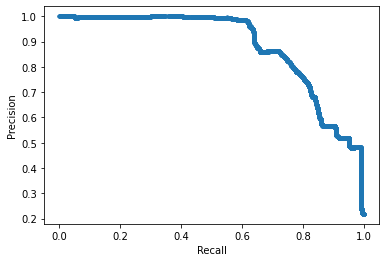

AUC: 0.95
Iteration: 15
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0054 
[INFO] Training phase... Elapsed time: 58 seconds



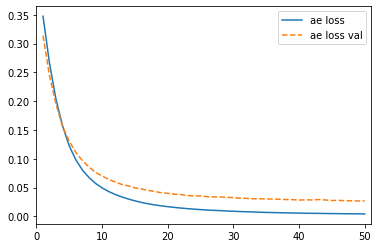

PR AUC: 0.89


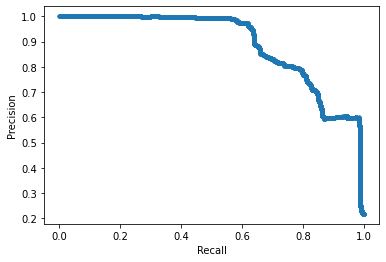

AUC: 0.96
Iteration: 16
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0044 
[INFO] Training phase... Elapsed time: 58 seconds



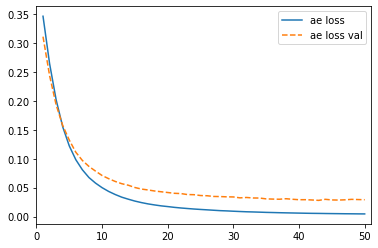

PR AUC: 0.86


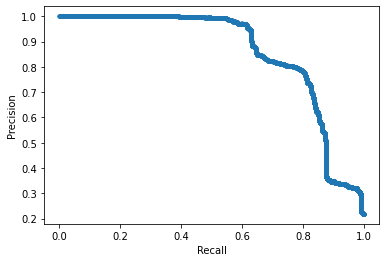

AUC: 0.91
Iteration: 17
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 58 seconds



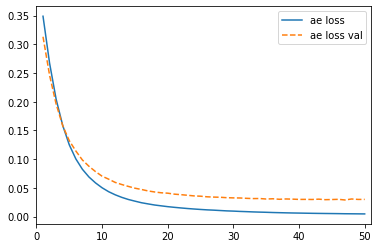

PR AUC: 0.85


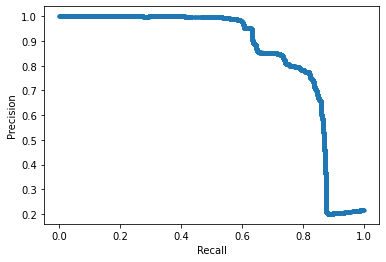

AUC: 0.86
Iteration: 18
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0051 
[INFO] Training phase... Elapsed time: 58 seconds



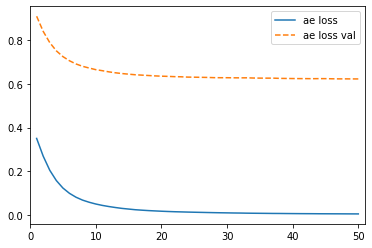

PR AUC: 0.86


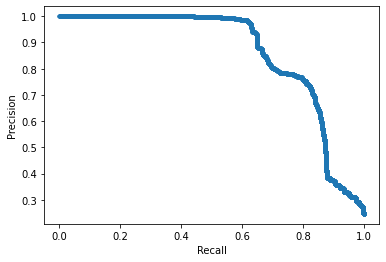

AUC: 0.92
Iteration: 19
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0046 
[INFO] Training phase... Elapsed time: 58 seconds



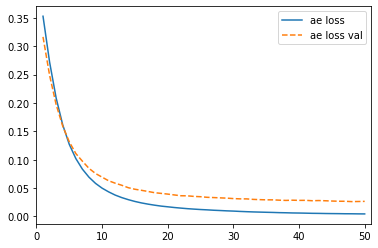

PR AUC: 0.86


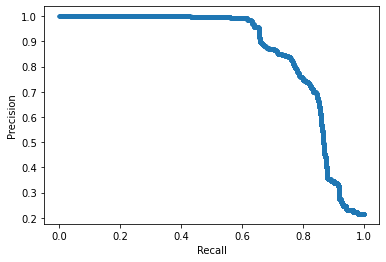

AUC: 0.89
Iteration: 20
[INFO] Starting training phase...
Epoch [ 50/50] | Step [ 70/79]| ae_loss: 0.0045 
[INFO] Training phase... Elapsed time: 58 seconds



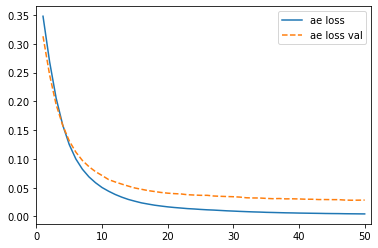

PR AUC: 0.85


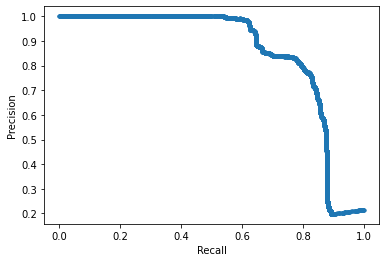

AUC: 0.87


In [8]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_KDDCUP99_REV(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']).to(device), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']).to(device), 
                                              torch.tensor(dataset['y_val'].to_numpy()).to(device))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']).to(device), 
                                              torch.tensor(dataset['y_test'].to_numpy()).to(device))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = BaselineTrainer(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    ae_loss, ae_loss_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(y_true, yP)
    pr = trainer.pr_auc(y_true, yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

    NAME_MODEL = f'BASELINE_{DATASET}Rev_{i}.ckpt'
    torch.save(trainer.AE.state_dict(), os.path.join(WORK_SPACE, NAME_MODEL))

In [10]:
auc_list

[0.9228991970241094,
 0.8767645593043789,
 0.9330786583721928,
 0.9633043165263189,
 0.9362072286265483,
 0.8881778511592311,
 0.8722514675187254,
 0.8788201498802772,
 0.9116192939715544,
 0.9381034452378427,
 0.9356113523152078,
 0.9659501433219839,
 0.9178748684954721,
 0.9480985532541266,
 0.9550276922130477,
 0.9148431855929807,
 0.8620873477289859,
 0.9176909862322692,
 0.8940395868733502,
 0.8667092436288355]

In [11]:
pr_list

[0.8634579040289752,
 0.8451399664443633,
 0.8772717838525725,
 0.904646489099512,
 0.8732287230742688,
 0.8458730579419358,
 0.8520295696500382,
 0.8481178768650794,
 0.8674357229612093,
 0.871701615255212,
 0.8674231072613179,
 0.9093602541892123,
 0.8718265056535921,
 0.8834432466774862,
 0.8910582547846625,
 0.8571352738583004,
 0.8475575659921739,
 0.8601426999389594,
 0.8598474484314087,
 0.8529448717493371]

In [14]:
meanAUC_PRAUC(auc_list, pr_list, 'Baseline_KDDCUP99Rev')

AUC:
[0.9228991970241094, 0.8767645593043789, 0.9330786583721928, 0.9633043165263189, 0.9362072286265483, 0.8881778511592311, 0.8722514675187254, 0.8788201498802772, 0.9116192939715544, 0.9381034452378427, 0.9356113523152078, 0.9659501433219839, 0.9178748684954721, 0.9480985532541266, 0.9550276922130477, 0.9148431855929807, 0.8620873477289859, 0.9176909862322692, 0.8940395868733502, 0.8667092436288355]
**************
PR AUC:
[0.8634579040289752, 0.8451399664443633, 0.8772717838525725, 0.904646489099512, 0.8732287230742688, 0.8458730579419358, 0.8520295696500382, 0.8481178768650794, 0.8674357229612093, 0.871701615255212, 0.8674231072613179, 0.9093602541892123, 0.8718265056535921, 0.8834432466774862, 0.8910582547846625, 0.8571352738583004, 0.8475575659921739, 0.8601426999389594, 0.8598474484314087, 0.8529448717493371]
**************
AUC
0.91 +/- 0.01
95% confidence level, average auc would be between 0.90 and 0.93
**************
PR AUC
0.87 +/- 0.01
95% confidence level, average auc woul

---